In [89]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))
df_raw['churn_concern'] = df_raw['churn_concern'].fillna(0).astype(int)

In [91]:
# Converted all cases fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours']

for case_type in case_types:
    df_raw[case_type] = df_raw[case_type].fillna(df_raw[case_type].mean()).astype(int)

In [92]:
df_raw.loc[df_raw.plan=='PLAN-S-19Q1', 'annual_revenue'].fillna(round(df_raw.annual_revenue[df_raw.plan == 'PLAN-S-19Q1'].mean(), 2))

2        5551.79
16       1371.75
20          0.00
23          0.00
28          0.00
          ...   
5876    49879.88
5882        0.00
5883        0.00
5886        0.00
5888        0.00
Name: annual_revenue, Length: 1530, dtype: float64

In [102]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    plan_revenue_mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    
    if pd.isnull(plan_revenue_mean):
        revenue = 0
    else:
        revenue = plan_revenue_mean
    print(plan, revenue)
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

BUSINESS ONE 0
PLAN-XL-19Q1 5487215.54
PLAN-S-19Q1 49879.88
PLAN-L-19Q1 421205.5
PLAN-360-19Q1 777413.32
PLAN-M-19Q1 164494.6
PLAN-360-TRANSITION 3178724.38
PLAN-M-17Q2 93985.95
PLAN-XS 0
PLAN-S-17Q2 52690.72
PREMIUM 0.0
BRONZE 0
ULTIMATE 0.0
STANDARD 17.31
LISTNSEND 0
GROW 0
PLAN-M 0
START - LEGACY 0
PLAN-L-17Q2 147113.29
PLAN-XS-17Q2 104.93
TRIAL 0
BUSINESS + 0
CUSTOM 2789.87
BASIC 0
BUSINESS 0
ULTIMATE PLUS 0
START 0
PLAN-S 9103.57
PLAN-L 0.0
CUSTOM XL -704.16
GOLD 0
LIST N SEND SILVER 0
PLAN-360-17Q2 79331.55
L&S - STANDARD 0
L&S - ULTIMATE 0
L&S - PREMIUM 0
NETO XL 212999.7
ENTERPRISE 0
PLAN-M-US 454060.33
PLAN-S-US 58476.84
PLAN-360-US 150677.18
PLAN-L-US 0


In [106]:
print(df_raw.username[df_raw.plan=='PLAN-L-19Q1'], df_raw[df_raw.plan=='PLAN-L-19Q1'].annual_revenue)

3       N002628
4       N002758
6       N002681
8       N001055
9       N001227
         ...   
5834    N065272
5839    N065064
5840    N065468
5866    N065872
5887    N066090
Name: username, Length: 516, dtype: object 3       264824.80
4       896405.29
6             NaN
8       913175.82
9       110406.65
          ...    
5834         0.00
5839         0.00
5840         0.00
5866         0.00
5887          NaN
Name: annual_revenue, Length: 516, dtype: float64


In [23]:
import pandas as pd

def quick_analysis(df):
 print("Data Types:")
 print(df.dtypes)
 print("Rows and Columns:")
 print(df.shape)
 print("Column Names:")
 print(df.columns)
 print("Null Values:")
 print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    
quick_analysis(df_raw)

Data Types:
username                                   object
merchant                                   object
canceldate                         datetime64[ns]
licence_registration_date          datetime64[ns]
days_active                                 int64
nps                                       float64
licence_status                             object
cancel_reason                              object
cancel_details                             object
team                                       object
vertical                                   object
plans                                      object
plan                                       object
last_login_days                           float64
last_login_concern                        float64
changing_platform                          object
new_platform                               object
salesperson                                object
golive_date                        datetime64[ns]
golive_days                           

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2deabb00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2e0fdc18>]], dtype=object)

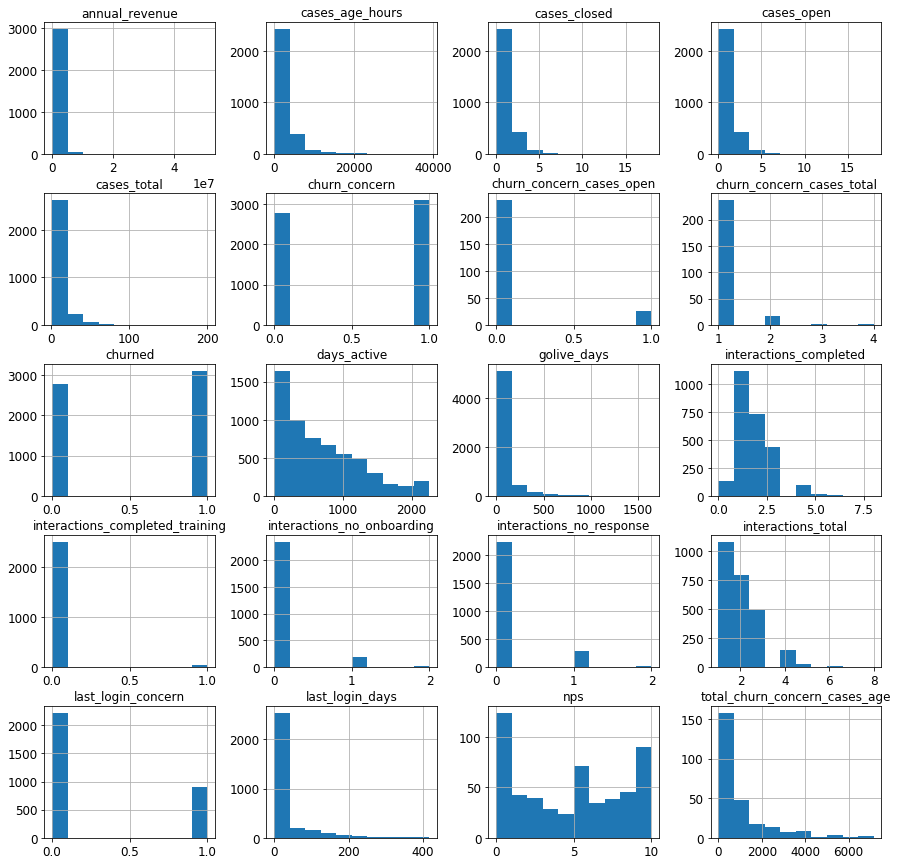

In [4]:
import matplotlib.pyplot as plt
df_raw[df_raw.dtypes[(df_raw.dtypes=="float64")|(df_raw.dtypes=="int64")]
                        .index.values].hist(figsize=[15,15])

In [5]:
# A more standard way to one-hot encoding

dummy_cols = ['account_status']
df_raw = pd.get_dummies(df_raw, columns = dummy_cols)
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'nps', 'licence_status', 'cancel_reason',
       'cancel_details', 'team', 'vertical', 'plans', 'plan',
       'last_login_days', 'last_login_concern', 'changing_platform',
       'new_platform', 'salesperson', 'golive_date', 'golive_days', 'url',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours',
       'annual_revenue', 'interactions_total', 'interactions_completed',
       'interactions_no_response', 'interactions_no_onboarding',
       'interactions_completed_training', 'churn_concern_cases_total',
       'churn_concern_cases_open', 'total_churn_concern_cases_age', 'churned',
       'churn_concern', 'account_status_Active', 'account_status_Cancelled',
       'account_status_Draft', 'account_status_Hold',
       'account_status_Suspended'],
      dtype='object')

In [355]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
last_login_categories
pd.value_counts(df_raw['last_login_categories'])

few_days     174
month        143
week         125
fortnight    114
day           80
Name: last_login_categories, dtype: int64

In [356]:
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'is_suspended', 'nps', 'licence_status', 'cancel_reason',
       'cancel_details', 'team', 'vertical', 'plans', 'plan',
       'last_login_days', 'last_login_concern', 'changing_platform',
       'new_platform', 'salesperson', 'golive_date', 'golive_days', 'url',
       'cases_total', 'cases_open', 'annual_revenue', 'interactions_total',
       'interactions_completed', 'interactions_no_response',
       'interactions_no_onboarding', 'interactions_completed_training',
       'churn_concern_cases_total', 'churn_concern_cases_open',
       'total_churn_concern_cases_age', 'churned', 'churn_concern',
       'account_status_Active', 'account_status_Cancelled',
       'account_status_Draft', 'account_status_Hold',
       'account_status_Suspended', 'last_login_categories'],
      dtype='object')

In [357]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [358]:
# Drop columns

df_raw = df_raw.drop(columns=['account_status_Draft', 'account_status_Active', 'account_status_Cancelled', 'changing_platform', 'new_platform', 'licence_status', 'canceldate', 'cancel_details', 'cancel_reason', 'churned'])

In [359]:
len(df_raw[df_raw.churn_concern==1]), len(df_raw[df_raw.churn_concern==0]), len(df_raw)

(3109, 2780, 5889)

In [360]:
# this code was an attempt to do over sampling

#df_copy = df_raw.copy()
#df_copy.append([df_raw[df_raw.churn_concern==1]]*100,ignore_index=True)
#df_copy.append([df_raw[df_raw.churn_concern==0]]*100,ignore_index=True)
#len(df_copy[df_copy.churn_concern==1]), len(df_copy[df_copy.churn_concern==0]), len(df_copy)

In [361]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))
df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))
df_raw.churn_concern = df_raw.churn_concern.fillna(0)

In [362]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)

In [363]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)

In [388]:
X_train.tail(1), X_valid.tail(1)

(      username  merchant  days_active  is_suspended       nps  team  vertical  \
 5388      5304      5541          317             0  4.406716     9         7   
 
       plans  plan  last_login_days  ...  interactions_completed_training_na  \
 5388     31    31              0.0  ...                               False   
 
       churn_concern_cases_total_na  churn_concern_cases_open_na  \
 5388                          True                         True   
 
       total_churn_concern_cases_age_na  last_login_categories_day  \
 5388                              True                          0   
 
       last_login_categories_few_days  last_login_categories_week  \
 5388                               0                           0   
 
       last_login_categories_fortnight  last_login_categories_month  \
 5388                                0                            0   
 
       last_login_categories_nan  
 5388                          1  
 
 [1 rows x 71 columns],
       usern

In [364]:
n_valid, n_trn

(500, 5389)

In [383]:
len(X_valid), len(X_valid.columns), len(X_train), len(X_train.columns)

(500, 71, 5389, 71)

In [384]:
y_train, y_valid = split_vals(y_trn, n_trn)
#raw_train, raw_valid = split_vals(df_raw, n_trn)
len(y_valid), len(y_train)

(500, 5389)

In [385]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [386]:
validate_predictions = m.predict(X_valid)

In [387]:
validate_predictions

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 

In [289]:
from sklearn.metrics import f1_score, accuracy_score

In [290]:
accuracy_score(y_valid, validate_predictions)

0.924

In [291]:
f1_score(y_valid, validate_predictions)

0.7790697674418605

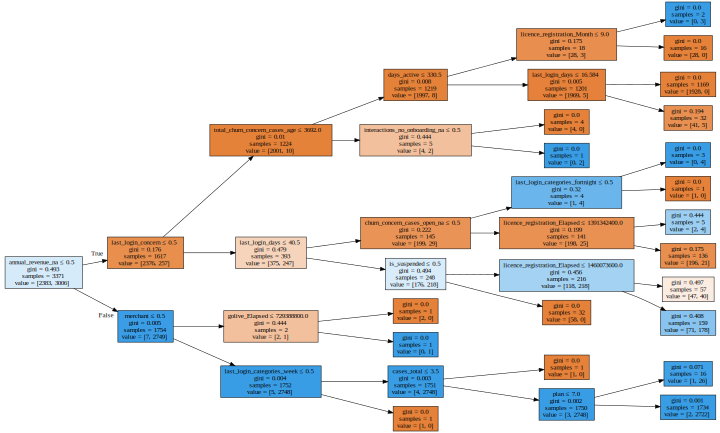

In [292]:
draw_tree(m.estimators_[10], df_trn, precision=3)

In [293]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
56,annual_revenue_na,0.464906
9,last_login_days,0.302785
53,last_login_concern_na,0.101526
16,annual_revenue,0.038533
10,last_login_concern,0.015706
58,interactions_completed_na,0.010404
60,interactions_no_onboarding_na,0.009631
57,interactions_total_na,0.009456
59,interactions_no_response_na,0.009296
61,interactions_completed_training_na,0.007317


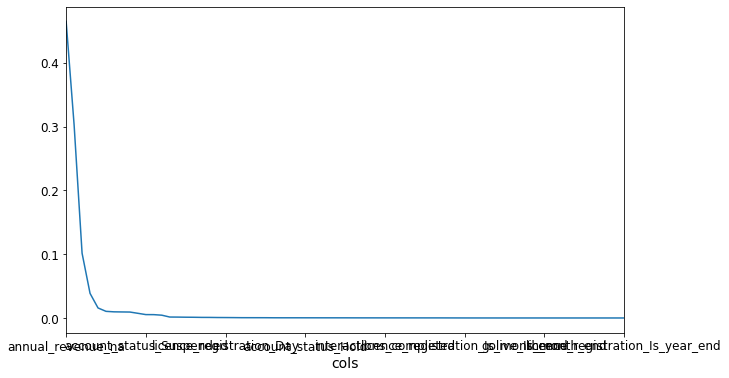

In [294]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [295]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

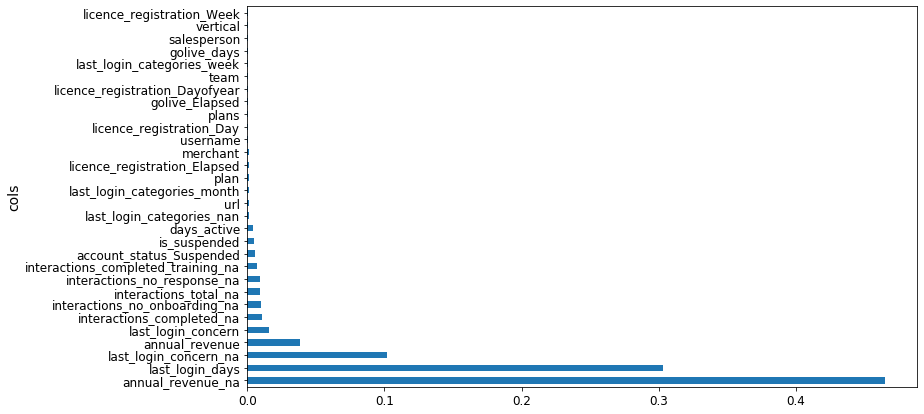

In [296]:
plot_fi(fi[:30]);

In [297]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

12

In [298]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [299]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
m.oob_score_

0.965485247726851

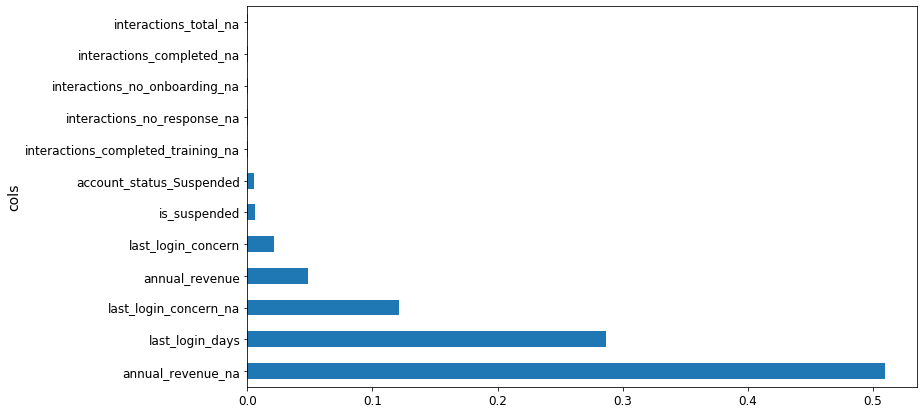

In [300]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [301]:
from scipy.cluster import hierarchy as hc

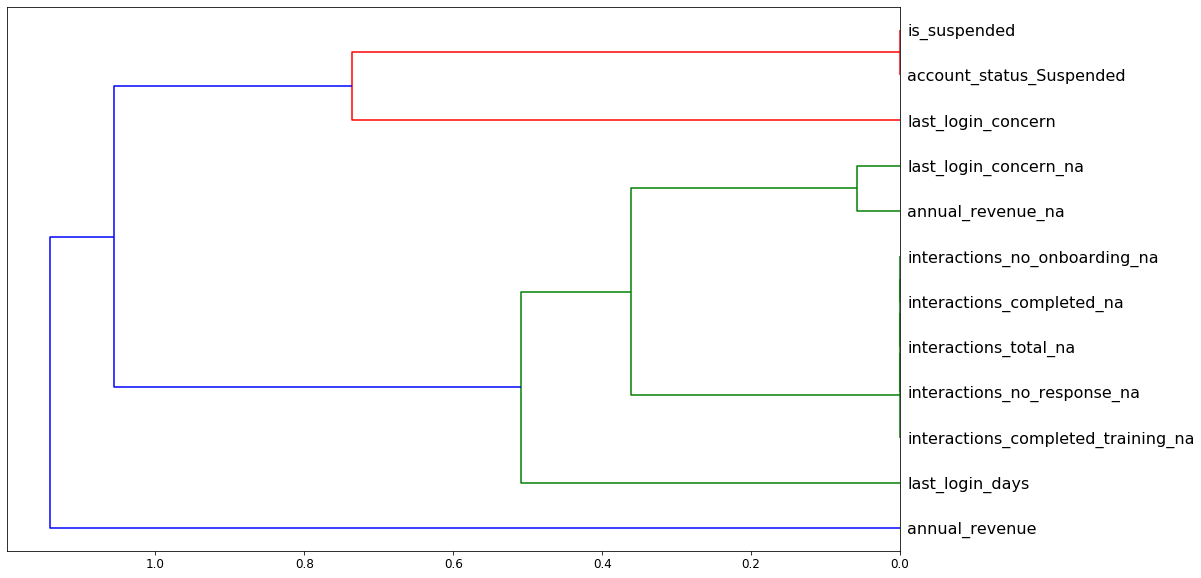

In [302]:

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [303]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [304]:
get_oob(df_keep)

0.9641863054370013

In [305]:
correlated_fields = ['annual_revenue_na', 'interactions_no_response_na', 'interactions_no_onboarding_na', 'interactions_total_na', 'interactions_completed_training_na', 'account_status_Suspended', 'is_suspended']
for c in (correlated_fields):
    print(c, get_oob(df_keep.drop(c, axis=1)), get_oob(df_keep.drop(c, axis=1))-0.9660419372796437)

annual_revenue_na 0.9643718686212656 -0.002597884579699339
interactions_no_response_na 0.9638151790684728 -0.0027834477639636646
interactions_no_onboarding_na 0.9638151790684728 -0.002412321395435124
interactions_total_na 0.96325848951568 -0.002412321395435124
interactions_completed_training_na 0.964742994989794 -0.002597884579699339
account_status_Suspended 0.9634440526999444 -0.0022267582111709094
is_suspended 0.9627017999628874 -0.002597884579699339


In [306]:
get_oob(df_keep.drop(correlated_fields, axis=1))

0.9582482835405456

In [307]:
to_drop = ['is_suspended', 'interactions_no_onboarding_na', 'annual_revenue_na']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [308]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

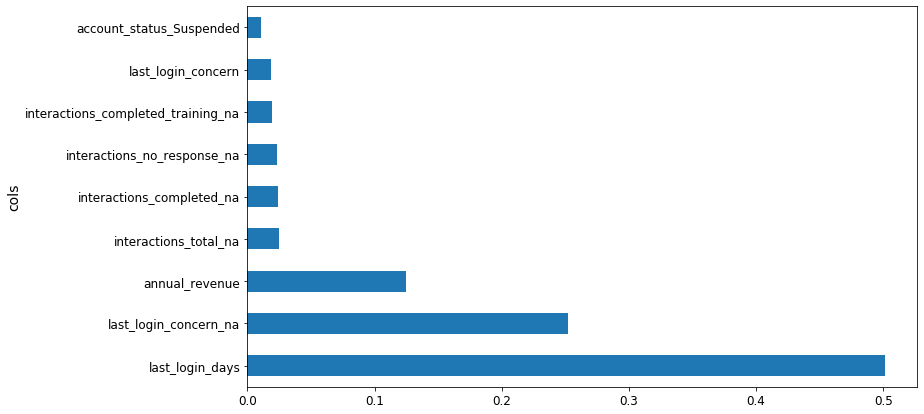

In [309]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [310]:
validate_predictions = m.predict(X_valid)
accuracy_score(y_valid, validate_predictions), f1_score(y_valid, validate_predictions)

(0.928, 0.7692307692307692)